ÁSZF READABILITY - FEATURE-BASED APPROACH

LOADING DATA

Training data: 2906 samples
Test data: 132 samples

Label distribution (training):
  Class 1:  132 ( 4.54%)
  Class 2:  318 (10.94%)
  Class 3:  634 (21.82%)
  Class 4:  925 (31.83%)
  Class 5:  897 (30.87%)

EXTRACTING FEATURES

Extracting features from training data...
Extracting features from test data...

✓ Features extracted: 28 features

Feature names:
   1. char_count
   2. word_count
   3. sentence_count
   4. avg_sentence_length
   5. max_sentence_length
   6. std_sentence_length
   7. avg_word_length
   8. max_word_length
   9. std_word_length
  10. long_word_ratio
  11. very_long_word_ratio
  12. comma_count
  13. comma_ratio
  14. semicolon_count
  15. colon_count
  16. paren_count
  17. paren_ratio
  18. bracket_count
  19. quote_count
  20. slash_count
  21. dash_count
  22. numbering_count
  23. percent_count
  24. number_ratio
  25. legal_suffix_count
  26. reference_count
  27. uppercase_ratio
  28. complexity_sc

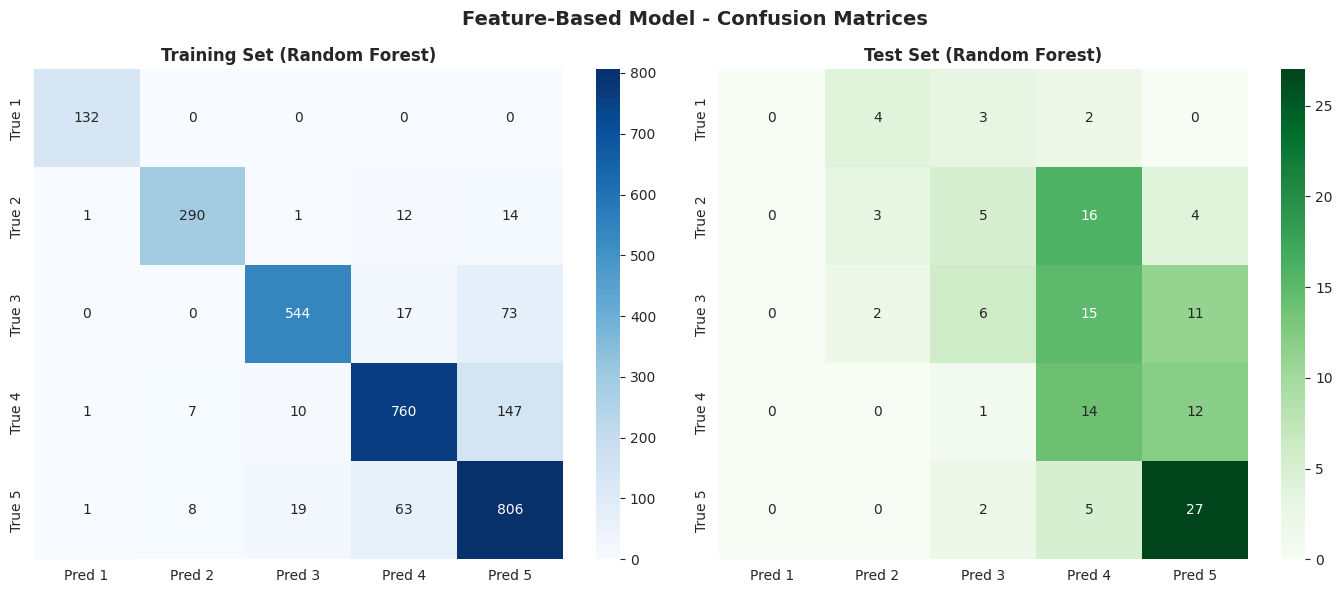

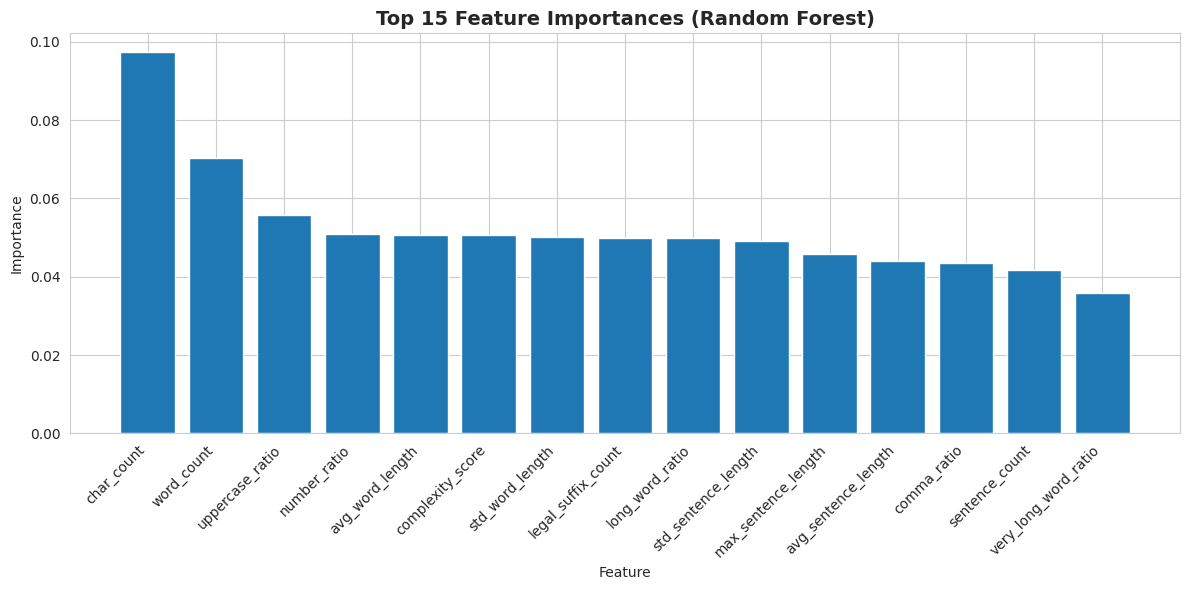

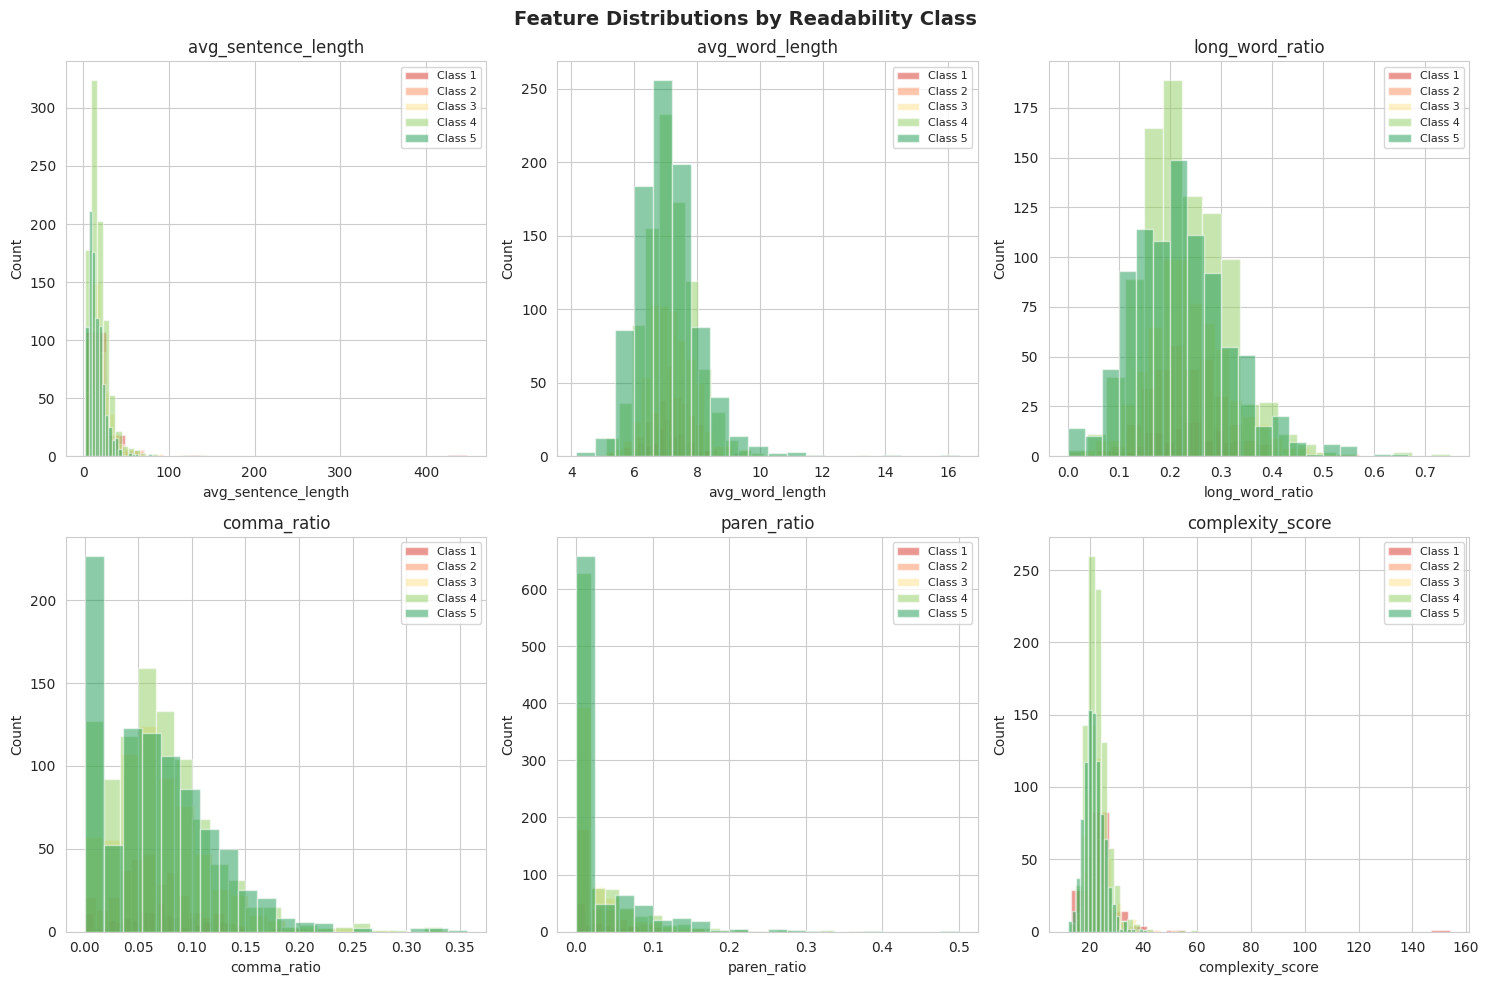

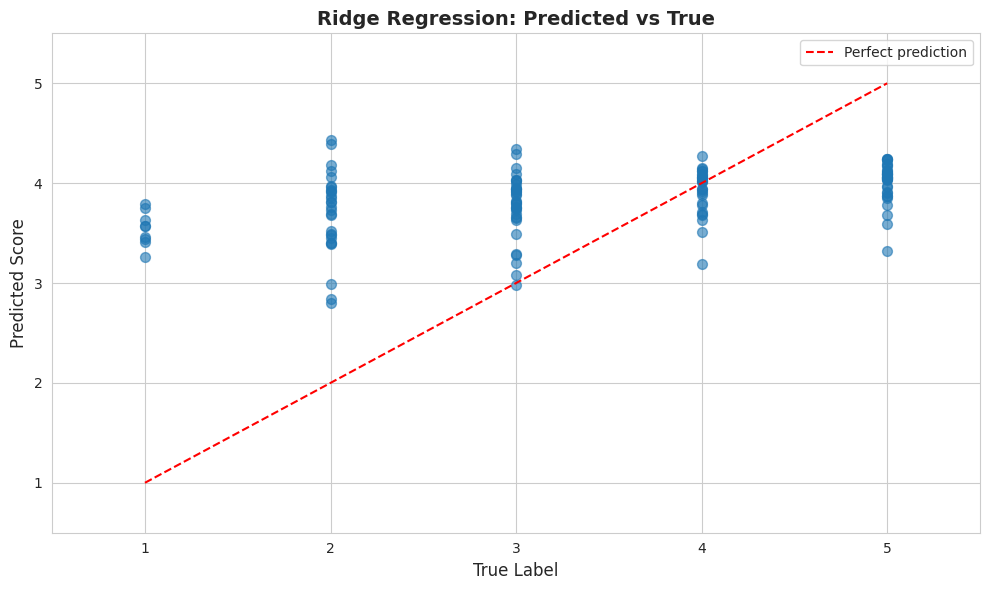


ORDINAL METRICS

Random Forest:
  Test Exact Accuracy:    0.3788
  Test Within-1 Accuracy: 0.7121
  Test Within-2 Accuracy: 0.9545

Ridge Regression:
  Test Exact Accuracy:    0.2424
  Test Within-1 Accuracy: 0.7803
  Test Within-2 Accuracy: 0.9621

PER-CLASS RECALL COMPARISON

Recall by class:
------------------------------------------------------------
Class      Best Model      Ridge          
------------------------------------------------------------
Class 1    0.0000          0.0000         
Class 2    0.1071          0.0000         
Class 3    0.1765          0.1765         
Class 4    0.5185          0.9630         
Class 5    0.7941          0.0000         

SUMMARY

FEATURE-BASED APPROACH RESULTS:

Features: 28 linguistic features
  - Sentence/word length statistics
  - Punctuation patterns
  - Parentheses and reference counts
  - Hungarian-specific patterns

Best Classifier: Random Forest
  - CV Accuracy: 0.4160 ± 0.0063
  - Test Accuracy: 0.3788
  - Test Within-1: 0.7121


In [7]:
"""
ÁSZF Readability - Simple Feature-Based Approach

Uses interpretable linguistic features known to correlate with readability:
- Sentence/word length statistics
- Punctuation patterns (legal text often has complex punctuation)
- Vocabulary complexity (long words, rare characters)
- Structural features (parentheses, references, numbering)

Models: Logistic Regression, Random Forest, XGBoost
"""

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import re

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

print("=" * 80)
print("ÁSZF READABILITY - FEATURE-BASED APPROACH")
print("=" * 80)


# =============================================================================
# FEATURE EXTRACTION
# =============================================================================
def extract_features(text):
    """
    Extract linguistic features from Hungarian legal text.
    Returns a dictionary of features.
    """
    features = {}

    # Basic length features
    features['char_count'] = len(text)
    features['word_count'] = len(text.split())

    # Sentence features (split on . ! ? and newlines)
    sentences = re.split(r'[.!?]\s+|\n+', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    features['sentence_count'] = len(sentences) if sentences else 1

    sent_lengths = [len(s.split()) for s in sentences] if sentences else [0]
    features['avg_sentence_length'] = np.mean(sent_lengths)
    features['max_sentence_length'] = np.max(sent_lengths) if sent_lengths else 0
    features['std_sentence_length'] = np.std(sent_lengths) if len(sent_lengths) > 1 else 0

    # Word features
    words = text.split()
    word_lengths = [len(w) for w in words] if words else [0]
    features['avg_word_length'] = np.mean(word_lengths)
    features['max_word_length'] = np.max(word_lengths) if word_lengths else 0
    features['std_word_length'] = np.std(word_lengths) if len(word_lengths) > 1 else 0

    # Long words (>10 chars) - common in legal Hungarian
    features['long_word_ratio'] = sum(1 for w in words if len(w) > 10) / len(words) if words else 0
    features['very_long_word_ratio'] = sum(1 for w in words if len(w) > 15) / len(words) if words else 0

    # Punctuation features
    features['comma_count'] = text.count(',')
    features['comma_ratio'] = text.count(',') / len(words) if words else 0
    features['semicolon_count'] = text.count(';')
    features['colon_count'] = text.count(':')

    # Parentheses (common in legal text for clarifications)
    features['paren_count'] = text.count('(') + text.count(')')
    features['paren_ratio'] = features['paren_count'] / len(words) if words else 0

    # Brackets and references
    features['bracket_count'] = text.count('[') + text.count(']')
    features['quote_count'] = text.count('"') + text.count('„') + text.count('"')

    # Legal/formal indicators
    features['slash_count'] = text.count('/')
    features['dash_count'] = text.count('-') + text.count('–') + text.count('—')

    # Numbering patterns (1. 2. a) b) etc.)
    features['numbering_count'] = len(re.findall(r'\b\d+\.\s|\b[a-z]\)\s', text))

    # Percentage and currency (often in contracts)
    features['percent_count'] = text.count('%')
    features['number_ratio'] = len(re.findall(r'\d+', text)) / len(words) if words else 0

    # Hungarian-specific: long compound words often end in these
    features['legal_suffix_count'] = len(re.findall(
        r'(ség|ság|ként|ról|ről|ban|ben|nak|nek|val|vel|hoz|hez|höz|tól|től|ig|ért)\b',
        text.lower()
    ))

    # Reference patterns (common in legal: "az 1. pontban", "a fenti", etc.)
    features['reference_count'] = len(re.findall(
        r'(fenti|lenti|előző|következő|jelen|említett|hivatkozott|\d+\.\s*(pont|bekezdés|§|cikk))',
        text.lower()
    ))

    # Uppercase ratio (abbreviations, emphasis)
    upper_chars = sum(1 for c in text if c.isupper())
    features['uppercase_ratio'] = upper_chars / len(text) if text else 0

    # Complexity score (simple heuristic)
    features['complexity_score'] = (
        features['avg_sentence_length'] * 0.3 +
        features['avg_word_length'] * 2 +
        features['long_word_ratio'] * 10 +
        features['comma_ratio'] * 5 +
        features['paren_ratio'] * 10
    )

    return features


def extract_features_df(texts):
    """Extract features for a list of texts, return DataFrame."""
    feature_list = []
    for text in texts:
        features = extract_features(text)
        feature_list.append(features)
    return pd.DataFrame(feature_list)


# =============================================================================
# LOAD DATA
# =============================================================================
print("\n" + "=" * 80)
print("LOADING DATA")
print("=" * 80)

train_path = Path('/content/sample_data/train.csv')
test_path = Path('/content/sample_data/test.csv')

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

print(f"\nTraining data: {len(df_train)} samples")
print(f"Test data: {len(df_test)} samples")

print("\nLabel distribution (training):")
for label in sorted(df_train['label_numeric'].unique()):
    count = (df_train['label_numeric'] == label).sum()
    pct = count / len(df_train) * 100
    print(f"  Class {label}: {count:4d} ({pct:5.2f}%)")


# =============================================================================
# EXTRACT FEATURES
# =============================================================================
print("\n" + "=" * 80)
print("EXTRACTING FEATURES")
print("=" * 80)

print("\nExtracting features from training data...")
X_train_df = extract_features_df(df_train['text'].tolist())
y_train = df_train['label_numeric'].values

print("Extracting features from test data...")
X_test_df = extract_features_df(df_test['text'].tolist())
y_test = df_test['label_numeric'].values

print(f"\n✓ Features extracted: {X_train_df.shape[1]} features")
print(f"\nFeature names:")
for i, col in enumerate(X_train_df.columns):
    print(f"  {i+1:2d}. {col}")


# =============================================================================
# FEATURE ANALYSIS
# =============================================================================
print("\n" + "=" * 80)
print("FEATURE ANALYSIS BY CLASS")
print("=" * 80)

# Add labels to feature df for analysis
X_train_df['label'] = y_train

print("\nMean feature values by class:")
print("-" * 80)

# Select key features to display
key_features = [
    'avg_sentence_length', 'avg_word_length', 'long_word_ratio',
    'comma_ratio', 'paren_ratio', 'reference_count', 'complexity_score'
]

for feat in key_features:
    print(f"\n{feat}:")
    for label in sorted(df_train['label_numeric'].unique()):
        mean_val = X_train_df[X_train_df['label'] == label][feat].mean()
        std_val = X_train_df[X_train_df['label'] == label][feat].std()
        print(f"  Class {label}: {mean_val:8.3f} ± {std_val:.3f}")

# Remove label column for modeling
X_train_df = X_train_df.drop('label', axis=1)


# =============================================================================
# FEATURE CORRELATION WITH LABEL
# =============================================================================
print("\n" + "=" * 80)
print("FEATURE-LABEL CORRELATIONS")
print("=" * 80)

correlations = []
for col in X_train_df.columns:
    corr = np.corrcoef(X_train_df[col].values, y_train)[0, 1]
    correlations.append((col, corr))

correlations.sort(key=lambda x: abs(x[1]), reverse=True)

print("\nTop features correlated with readability (higher = easier to read):")
print("-" * 60)
for feat, corr in correlations[:15]:
    direction = "↑ easier" if corr > 0 else "↓ harder"
    print(f"  {feat:25s}: {corr:+.3f} ({direction})")


# =============================================================================
# PREPARE DATA
# =============================================================================
print("\n" + "=" * 80)
print("PREPARING DATA")
print("=" * 80)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

print(f"\n✓ Features scaled")
print(f"  Train shape: {X_train_scaled.shape}")
print(f"  Test shape: {X_test_scaled.shape}")


# =============================================================================
# MODEL TRAINING AND COMPARISON
# =============================================================================
print("\n" + "=" * 80)
print("MODEL COMPARISON (5-Fold CV)")
print("=" * 80)

models = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        C=1.0,
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nCross-validation results:")
print("-" * 60)

cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    cv_results[name] = scores
    print(f"  {name:25s}: {scores.mean():.4f} ± {scores.std():.4f}")

best_model_name = max(cv_results, key=lambda x: cv_results[x].mean())
print(f"\n✓ Best model: {best_model_name}")


# =============================================================================
# TRAIN BEST MODEL
# =============================================================================
print("\n" + "=" * 80)
print(f"TRAINING {best_model_name.upper()}")
print("=" * 80)

best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)

# Predictions
train_preds = best_model.predict(X_train_scaled)
test_preds = best_model.predict(X_test_scaled)

print("\nTraining Set Results:")
print(classification_report(y_train, train_preds,
                          target_names=[f'Class {i}' for i in range(1, 6)],
                          digits=4))

print("\nTest Set Results:")
print(classification_report(y_test, test_preds,
                          target_names=[f'Class {i}' for i in range(1, 6)],
                          digits=4))


# =============================================================================
# ALSO TRY REGRESSION APPROACH
# =============================================================================
print("\n" + "=" * 80)
print("REGRESSION APPROACH (Ridge)")
print("=" * 80)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

train_preds_reg = ridge.predict(X_train_scaled)
test_preds_reg = ridge.predict(X_test_scaled)

# Round to nearest class
train_preds_rounded = np.clip(np.round(train_preds_reg), 1, 5).astype(int)
test_preds_rounded = np.clip(np.round(test_preds_reg), 1, 5).astype(int)

print("\nRidge Regression (rounded predictions):")
print(f"  Train MAE: {np.abs(train_preds_reg - y_train).mean():.3f}")
print(f"  Test MAE:  {np.abs(test_preds_reg - y_test).mean():.3f}")
print(f"  Train Accuracy: {(train_preds_rounded == y_train).mean():.4f}")
print(f"  Test Accuracy:  {(test_preds_rounded == y_test).mean():.4f}")

print("\nTest Set Results (Ridge Regression):")
print(classification_report(y_test, test_preds_rounded,
                          target_names=[f'Class {i}' for i in range(1, 6)],
                          digits=4))


# =============================================================================
# VISUALIZATIONS
# =============================================================================
print("\n" + "=" * 80)
print("VISUALIZATIONS")
print("=" * 80)

output_dir = Path('../models/feature_based')
output_dir.mkdir(parents=True, exist_ok=True)

# 1. Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cm_train = confusion_matrix(y_train, train_preds)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=[f'Pred {i}' for i in range(1, 6)],
            yticklabels=[f'True {i}' for i in range(1, 6)])
axes[0].set_title(f'Training Set ({best_model_name})', fontsize=12, fontweight='bold')

cm_test = confusion_matrix(y_test, test_preds)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=[f'Pred {i}' for i in range(1, 6)],
            yticklabels=[f'True {i}' for i in range(1, 6)])
axes[1].set_title(f'Test Set ({best_model_name})', fontsize=12, fontweight='bold')

plt.suptitle('Feature-Based Model - Confusion Matrices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(output_dir / 'confusion_matrices.png', dpi=150)
plt.show()

# 2. Feature importance (if Random Forest or Gradient Boosting)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1][:15]

    plt.figure(figsize=(12, 6))
    plt.bar(range(15), importances[indices])
    plt.xticks(range(15), [X_train_df.columns[i] for i in indices], rotation=45, ha='right')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title(f'Top 15 Feature Importances ({best_model_name})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(output_dir / 'feature_importance.png', dpi=150)
    plt.show()

# 3. Feature distributions by class
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

plot_features = ['avg_sentence_length', 'avg_word_length', 'long_word_ratio',
                 'comma_ratio', 'paren_ratio', 'complexity_score']

colors = ['#d73027', '#fc8d59', '#fee08b', '#91cf60', '#1a9850']

for idx, feat in enumerate(plot_features):
    ax = axes[idx]
    for label in range(1, 6):
        mask = y_train == label
        data = X_train_df[feat].values[mask]
        ax.hist(data, bins=20, alpha=0.5, label=f'Class {label}', color=colors[label-1])
    ax.set_xlabel(feat)
    ax.set_ylabel('Count')
    ax.legend(fontsize=8)
    ax.set_title(feat)

plt.suptitle('Feature Distributions by Readability Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(output_dir / 'feature_distributions.png', dpi=150)
plt.show()

# 4. Regression predictions vs true
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_test, test_preds_reg, alpha=0.6, s=50)
ax.plot([1, 5], [1, 5], 'r--', label='Perfect prediction')
ax.set_xlabel('True Label', fontsize=12)
ax.set_ylabel('Predicted Score', fontsize=12)
ax.set_title('Ridge Regression: Predicted vs True', fontsize=14, fontweight='bold')
ax.legend()
ax.set_xlim(0.5, 5.5)
ax.set_ylim(0.5, 5.5)
plt.tight_layout()
plt.savefig(output_dir / 'regression_scatter.png', dpi=150)
plt.show()


# =============================================================================
# WITHIN-K ACCURACY
# =============================================================================
print("\n" + "=" * 80)
print("ORDINAL METRICS")
print("=" * 80)

def within_k_accuracy(true, pred, k=1):
    return (np.abs(true - pred) <= k).mean()

print(f"\n{best_model_name}:")
print(f"  Test Exact Accuracy:    {(test_preds == y_test).mean():.4f}")
print(f"  Test Within-1 Accuracy: {within_k_accuracy(y_test, test_preds, 1):.4f}")
print(f"  Test Within-2 Accuracy: {within_k_accuracy(y_test, test_preds, 2):.4f}")

print(f"\nRidge Regression:")
print(f"  Test Exact Accuracy:    {(test_preds_rounded == y_test).mean():.4f}")
print(f"  Test Within-1 Accuracy: {within_k_accuracy(y_test, test_preds_rounded, 1):.4f}")
print(f"  Test Within-2 Accuracy: {within_k_accuracy(y_test, test_preds_rounded, 2):.4f}")


# =============================================================================
# PER-CLASS ANALYSIS
# =============================================================================
print("\n" + "=" * 80)
print("PER-CLASS RECALL COMPARISON")
print("=" * 80)

print("\nRecall by class:")
print("-" * 60)
print(f"{'Class':<10} {'Best Model':<15} {'Ridge':<15}")
print("-" * 60)

for c in range(1, 6):
    mask = y_test == c
    if mask.sum() > 0:
        recall_best = (test_preds[mask] == c).sum() / mask.sum()
        recall_ridge = (test_preds_rounded[mask] == c).sum() / mask.sum()
        print(f"Class {c:<4} {recall_best:<15.4f} {recall_ridge:<15.4f}")


# =============================================================================
# SUMMARY
# =============================================================================
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)

print(f"""
FEATURE-BASED APPROACH RESULTS:

Features: {X_train_df.shape[1]} linguistic features
  - Sentence/word length statistics
  - Punctuation patterns
  - Parentheses and reference counts
  - Hungarian-specific patterns

Best Classifier: {best_model_name}
  - CV Accuracy: {cv_results[best_model_name].mean():.4f} ± {cv_results[best_model_name].std():.4f}
  - Test Accuracy: {(test_preds == y_test).mean():.4f}
  - Test Within-1: {within_k_accuracy(y_test, test_preds, 1):.4f}

Ridge Regression:
  - Test MAE: {np.abs(test_preds_reg - y_test).mean():.3f}
  - Test Accuracy: {(test_preds_rounded == y_test).mean():.4f}
  - Test Within-1: {within_k_accuracy(y_test, test_preds_rounded, 1):.4f}

Top predictive features (by correlation with readability):
""")

for feat, corr in correlations[:5]:
    print(f"  {feat}: {corr:+.3f}")

print(f"\nFiles saved to: {output_dir}")
print("\nSCRIPT COMPLETE!")